In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from queue import Queue
from copy import deepcopy
from nltk import Tree
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
from collections import deque
from collections import namedtuple
import pickle as pkl
import os

In [2]:
class Encoder:
    """
    Description
    --------------
    Class represeting the one-hot encoder of the states.
    """
    
    def __init__(self, categories=[4, 3, 3, 3, 2, 4]):
        """
        Description
        --------------
        Constructor of class Encoder.
        
        Parameters & Attributes
        --------------
        categories : List of length d where categories[i] is the number of categories feature i can take.
        d          : Int, the input dimension.
        dim        : Int, the one-hot encoded representation dimension
        
        """
        
        self.categories = categories
        self.d = len(categories)
#         self.dim = np.sum(categories) + self.d
                
    def transform(self, state_values):
        """
        Description
        --------------
        Encode the vector state representation with dummies.
        
        Parameters & Attributes
        --------------
        state_values : List of length d where the ith entry is either NaN or the the feature value.
        
        Returns
        --------------
        state_one_hot : 2D np.array representing the one-hot encoded state.
        """
        
        state_encoded = np.zeros((1, self.d), dtype = np.float32)
        for i, value in enumerate(state_values):
            if np.isnan(value):
                state_encoded[0, i] = -1

            else:
                state_encoded[0, i] = value
        
        return state_encoded

In [3]:
class StateDQN:
    """
    Description
    --------------
    Class representing a state, it also serves as Node representation
    for our Breadth First Search
    """
    
    def __init__(self, values, encoder, categories=[4, 3, 3, 3, 2, 4]):
        """
        Description
        --------------
        Constructor of class State.
        
        Parameters & Attributes
        --------------
        values     : List of length d (Input dimension):
                         - values[i] = NaN if i is an unobsorved feature.
                         - values[i] = value of feature i if it is observed.
        encocer    : sklearn.preprocessing._encoders.OneHotEncoder object.
        categories : List of length d where categories[i] is the number of categories feature i can take.
        observed   : List containing the observed features at this state.
        unobserved : List containing the unobserved features at this state.
        empty      : Boolean, whether it is the empty state or not.
        complete   : Boolean, whether all features are observed or not.
        """
        
        d = len(values)
        values_nans = np.isnan(values)
        self.encoder = encoder  # One-hot encoder, used in the approximate RL framework for state representation.
        self.values = values
        self.values_encoded = self.encode()
        self.categories = categories
        self.observed = np.arange(d)[np.invert(values_nans)]
        self.unobserved = np.arange(d)[values_nans]  # These are also the allowed query actions at this state
        self.empty = (len(self.observed) == 0)
        self.complete = (len(self.unobserved) == 0)
        
    def encode(self):
        """
        Description
        --------------
        Encode the state with dummy variables. To be used when a one-hot encoder is defined.
        
        Parameters
        --------------
        
        Returns
        --------------
        np.array of shape (1, #one_hot_representation_dim)
        """
        
        return self.encoder.transform(self.values)
        
    def __repr__(self):
        """
        Description
        --------------
        String representation of the state.
        """
        
        s = '| '
        for x in self.values:
            s += str(x) + ' | '
            
        return s
    
    def __str__(self):
        """
        Description
        --------------
        String representation of the state.
        """
        
        s = '| '
        for x in self.values:
            s += str(x) + ' | '
            
        return s

In [4]:
class DQNetwork(nn.Module):
    
    def __init__(self, input_size=15, out=8):
        """
        Description
        ---------------
        Constructor of DQNetwork class.
        
        Parameters
        ---------------
        input_size : Int, the one-hot encoding representation dimension.
        out        : Int, output dimension, equal to the number of possible actions.
        fc_1       : nn.Linear, first fully connected layer.
        fc_2       : nn.Linear, second fully connected layer.
        output     : nn.Linear, output fully connected layer.
        """
        
        super(DQNetwork, self).__init__()
        
        self.fc_1 = nn.Linear(input_size, 14)
        self.fc_2 = nn.Linear(14, 8)
        self.output = nn.Linear(8, out)
        
    def forward(self, x):
        """
        Description
        ---------------
        The forward pass.
        
        Parameters
        ---------------
        x : torch.tensor of dimension (batch_size, input_size)
        
        Returns
        ---------------
        torch.tensor of dimension (batch_size, out)
        """
        
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        return self.output(x)

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'next_state_unallowed'))


class Memory:
    
    """
    Class for the uniform experience replay memory.
    """
    
    def __init__(self, max_size):
        """
        Description
        -------------
        Constructor of class Memory.
        
        Parameters & Attributes
        -------------
        max_size   : Int, the maximum size of the replay memory.
        buffer     : collections.deque object of maximum length max_size, the container representing the replay memory.
        """
        
        self.buffer = deque(maxlen = max_size)
    
    def add(self, state, action, reward, next_state):
        """
        Description
        -------------
        Add experience to the replay buffer.
        
        Parameters
        -------------
        experience : 4-tuple representing a transition (state, action, reward, next_state).
                     - state      : Object of class State representing the state.
                     - action     : Int in {0, ..., d-1, d, d+1}, the action.
                     - reward     : Float, the reward.
                     - next_state : Object of class State representing the next state.
                     
        Returns
        -------------
        """
        
        next_state_unallowed = np.zeros(len(next_state.categories) + 2, dtype=np.float32)
        next_state_unallowed[next_state.observed] = 1
        self.buffer.append((torch.from_numpy(state.values_encoded), [action], torch.tensor([reward], dtype=torch.float32), 
                            torch.from_numpy(next_state.values_encoded), torch.from_numpy(next_state_unallowed).view(1, -1)))
    
    def sample(self, batch_size):
        """
        Description
        -------------
        Randomly sample "batch_size" experiences from the replay buffer.
        
        Parameters
        -------------
        batch_size : Int, the number of experiences to sample.
        
        Returns
        -------------
        Named tuple representing the sampled batch.
        """
        
        transitions = random.sample(self.buffer, batch_size)
        return Transition(*zip(*transitions))

In [6]:
class EnvironmentDQN:
    """
    Description
    --------------
    Class representing the environment, it can generate data points that start each episode,
    keep track of the current state, return the reward of an action taken at the current state,
    and transition to the next corresponding state.
    """
    
    def __init__(self, generator, rewards_queries, encoder, r_plus=5, r_minus=-5, split=3):
        """
        Description
        --------------
        Constructor of class Environment.
        
        Parameters & Attributes
        --------------
        generator       : Dict, - keys   : Feature variables.
                                - values : List of probability masses of each category of the corresponding feature.
        rewards_queries : Dict, - keys   : Feature variables.
                                - values : Reward of querying the value of the corresponding feature.
        encoder         : Object of class Encoder, the encoder mapping states to their one-hot representation.
        r_plus          : Int, reward of a correct report (default=5).
        r_minus         : Int, reward of an incorrect report (default=-5).
        split           : Int, the split point we use to define our concept.
        d               : Int, the number of feature variables.
        data_point      : List of length d, the data point starting the episode.
        label           : Boolean, the true label of data_point.
        state           : Object of class State, the current state.
        done            : Boolean, whether the episode is finished or not.
        """
        
        self.generator = generator
        self.categories = [len(v) for v in self.generator.values()]
        self.d = len(self.categories)
        self.rewards_queries = rewards_queries
        self.encoder = encoder
        self.r_plus = r_plus
        self.r_minus = r_minus
        self.split = split
        
    def generate(self):
        """
        Description
        --------------
        Generate a data point.
        
        Parameters
        --------------
        
        Returns
        --------------
        List with the values of each feature, it represents the data point.
        """
        
        return [np.random.choice(self.categories[i], p=self.generator[i]) for i in range(self.d)]
    
    def concept(self, data_point):
        """
        Description
        --------------
        Define the concept labeling the data points. we can define it as a decision tree for example.
        
        Parameters
        --------------
        data_point : List of length d, the data point to label.
        
        Returns
        --------------
        Int in {0, 1}, the label of the data point.
        """
        
        label = True
        i = 0
        while label and i <= self.d-1:
            if data_point[i] >= self.split:
                label = False
                
            i += 1
            
        return label
    
    def reset(self, data_point=None):
        """
        Description
        --------------
        Reset the environment to start a new episode. If data_point is specified, start the episode from it,
        otherwise generate it.
        
        Parameters
        --------------
        data_point : List of length d, the data point to label (default=None).
        
        Returns
        --------------
        """
        
        self.data_point = self.generate() if data_point is None else data_point
        self.label = self.concept(self.data_point)
        self.state = StateDQN([np.NaN for i in range(self.d)], self.encoder, categories=self.categories)
        self.done = False
    
    def step(self, action):
        """
        Description
        --------------
        Interract with the environment through an action taken at the current state.
        
        Parameters
        --------------
        action : Int in {0, ..., d-1, d, d+1}, 
                 - 0, ..., d-1 represent query actions.
                 - d, d+1 represent report actions.
        
        Returns
        --------------
        reward     : Int, the reward of taking this action at the current state.
        next_state : Object of class State, the next state.
        done       : Boolean, whether the episode is finished or not.
        """
        
        # Treating query actions.
        if action <= self.d-1:
            # If it is an allowed query action.
            if np.isnan(self.state.values[action]):
                reward = self.rewards_queries[action]
                values = self.state.values
                values[action] = self.data_point[action] # Reveal the value of the queried feature in the data point.
                self.state = StateDQN(values, self.encoder, self.categories)
                
            # If this query action is not allowed.
            else:
                print('unallowed')
            
        # Treating report actions.
        else:
            reward = self.r_plus if (action%self.d) == self.label else self.r_minus
            self.done = True
            
        return reward, self.state, self.done

In [7]:
class AgentDQN:
    """
    Description
    --------------
    Class describing a DQN agent
    """
    
    def __init__(self, gamma=.9, categories=[4, 3, 3, 3, 2, 4], labels=[0, 1], max_size_queries=int(1e4), max_size_reports=int(1e3)):
        """
        Description
        --------------
        Constructor of class AgentDQN.
        
        Parameters & Attributes
        --------------
        gamma            : Float in ]0, 1[, the discount factor (default=0.9).
        categories       : List of length d where categories[i] is the number of categories feature i can take.
        labels           : List of the possible labels.
        max_size         : Int, the maximum size of the experience replay memory.
        d                : Int, the number of feature variables.
        b                : Int, the number of class labels.
        actions          : List of all actions.
        actions_queries  : List of query actions.
        actions_report   : List of report actions.
        memory_queries   : Object of class Memory, replay buffer containing experiences with query actions only.
        memory_reports   : Object of class Memory, replay buffer containing experiences with report actions only.
        q_network        : Object of class DQNetwork, the current q-network estimating the Q-function.
        q_network_target : Object of class DQNetwork, the target q-network, it should have the same architecture as q_network.

        Returns
        --------------
        """
        
        self.gamma = gamma
        self.categories = categories
        self.labels = labels
        self.max_size_queries = max_size_queries
        self.max_size_reports = max_size_reports
        self.d = len(categories)
        self.b = len(labels)
        self.actions = range(self.d + len(labels))
        self.actions_queries = range(self.d)
        self.actions_report = [self.d + label for label in labels]
        self.memory_queries = Memory(max_size_queries)
        self.memory_reports = Memory(max_size_reports)
#         self.q_network = DQNetwork(input_size=np.sum(categories)+self.d, out=self.d+self.b)
#         self.q_network_target = DQNetwork(input_size=np.sum(categories)+self.d, out=self.d+self.b)
        self.q_network = DQNetwork(input_size=self.d, out=self.d+self.b)
        self.q_network_target = DQNetwork(input_size=self.d, out=self.d+self.b)
        
    def action_explore(self, state, epsilon=.1):
        """
        Description
        --------------
        Choose a query action and a report action at a state according to the epsilon-greedy policy.
        
        Parameters
        --------------
        state   : Object of class State.
        epsilon : Float in [0, 1], the probability of taking an action according to the greedy policy.
        
        Returns
        --------------
        query  : Int in {0, ..., d-1}
        report : Int in {d, d+1}
        """
        
        bern = np.random.binomial(1, epsilon)
        
        # Use conditions to avoid unnecessary forward passes on the Q-network.
        if bern == 1:
            query = np.random.choice(state.unobserved)
            report = np.random.randint(self.d, self.d + self.b)
            
        else:
            with torch.no_grad():
                q_values = self.q_network(torch.from_numpy(state.values_encoded))
                # Consider only q-values of allowed queries (for queries)
                q_queries_allowed = q_values[0, state.unobserved]
                # map argmax to the corresponding index in the allowed queries.
                query = state.unobserved[torch.argmax(q_queries_allowed).item()]
                # Take the greedy report action.
                report = torch.argmax(q_values[0, self.d:]).item()+self.d
            
        return query, report
    
    def action(self, state):
        """
        Description
        --------------
        Choose an action at a state greedy policy.
        
        Parameters
        --------------
        state   : Object of class State.
        
        Returns
        --------------
        action : Int in {0, ..., d-1, d, d+1}.
        """
        
        with torch.no_grad():
            q_values = self.q_network(torch.from_numpy(state.values_encoded))
            actions_allowed = list(state.unobserved) + [self.d+i for i in range(self.b)]
            q_values_allowed = q_values[0, actions_allowed]
            return actions_allowed[torch.argmax(q_values_allowed).item()]
    
    def update_target(self):
        """
        Description
        -------------
        Update the parameters of target_model with those of current_model

        Parameters
        -------------
        current_model, target_model : torch models
        """
        
        self.q_network_target.load_state_dict(self.q_network.state_dict())
    
    def pretrain(self, env, n_episodes):
        """
        Description
        --------------
        Fill the memory buffers with experiences in a pretraining phase.
        
        Parameters
        --------------
        env        : Object of class EnvironmentDQN.
        n_episodes : Int, number of episodes.
        
        Returns
        --------------
        """
        
        for episode in range(n_episodes):
            env.reset()
            state = deepcopy(env.state)
            while not state.complete:
                query, report = np.random.choice(state.unobserved), np.random.randint(self.d, self.d + self.b)
                reward, next_state, _ = env.step(report)
                self.memory_reports.add(state, report, reward, next_state)
                reward, next_state, _ = env.step(query)
                self.memory_queries.add(state, query, reward, next_state)
                state = deepcopy(next_state)
                
            report = np.random.randint(self.d, self.d + self.b)
            reward, next_state, _ = env.step(report)
            self.memory_reports.add(state, report, reward, next_state)   
            
    def train(self, env, n_train=1000, n_pretrain=100, epsilon_start=1, epsilon_stop=1e-4, decay_rate=1e-3, n_learn=5, batch_size=32, lr=1e-4, log_dir='runs_dqn/', 
             n_write=10, max_tau=50, double=True, n_save=1000, path_save='dqn_weights/'):
        """
        Description
        --------------
        Explore the environment and train the agent.
        
        Parameters
        --------------
        env           : Object of class EnvironmentDQN.
        n_train       : Int, number of training episodes.
        n_pretrain    : Int, number of pretraining episode.
        epsilon_start : Float in [0, 1], the starting epsilon parameter of the epsilon-greedy policy, it should be high.
        epsilon_stop  : Float in [0, 1], the last epsilon parameter of the epsilon-greedy policy, it should be small.
        decay_rate    : Float in [0, 1], the decay rate of epsilon.
        n_learn       : Int, the number of iterations between two consecutive learning phases.
        batch_size    : Int, the batch size for both replay buffers.
        lr            : Float, the learning rate.
        log_dir       : String, path of the folder where tensorboard events are stored.
        n_write       : Int, the number of iterations between two consecutive events writings.
        max_tau       : Int, the number of iterations between two consecutive target network updates.
        double        : Boolean, whether to use Double DQN or just DQN.
        n_save        : Int, the number of episodes between two consecutive saved models.
        path_save     : String, the path of the folder where weights will be saved.
        
        Returns
        --------------
        """
        
        writer = SummaryWriter(log_dir=log_dir)
        if not os.path.isdir(path_save):
            os.mkdir(path_save)
        
        # Pretrain the agent.
        self.pretrain(env, n_pretrain)
        epsilon = epsilon_start
        it = 0
        optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        variables = {'losses' : []}
        tau = 0
        for episode in range(n_train):
            env.reset()
            state = deepcopy(env.state)
            while not state.complete:
                query, report = self.action_explore(state, epsilon)
                it += 1
                tau += 1
                epsilon = epsilon_stop + (epsilon_start - epsilon_stop)*np.exp(-decay_rate*it)
                reward, next_state, _ = env.step(report)
                self.memory_reports.add(state, report, reward, next_state)
                reward, next_state, _ = env.step(query)
                self.memory_queries.add(state, query, reward, next_state)
                state = deepcopy(next_state)
                
                # Learning phase
                if it%n_learn == 0:
                    batch_queries = self.memory_queries.sample(batch_size)
                    batch_reports = self.memory_reports.sample(batch_size)
                    
                    states_batch_queries, states_batch_reports = torch.cat(batch_queries.state), torch.cat(batch_reports.state)
                    actions_batch_queries, actions_batch_reports = np.concatenate(batch_queries.action), np.concatenate(batch_reports.action)
                    rewards_batch_queries, rewards_batch_reports = torch.cat(batch_queries.reward), torch.cat(batch_reports.reward)
                    next_states_batch_queries, next_states_batch_reports = torch.cat(batch_queries.next_state), torch.cat(batch_reports.next_state)
                    next_states_batch_unallowed = torch.cat(batch_queries.next_state_unallowed)
                    
                    with torch.no_grad():
                        if double:
                            q_values = self.q_network(next_states_batch_queries)
                            q_values = q_values - 100*next_states_batch_unallowed
                            actions_values = torch.argmax(q_values, dim=1)
                            q_targets_queries = rewards_batch_queries + self.gamma*self.q_network_target(next_states_batch_queries)[np.arange(batch_size), actions_values].detach()

                        else:
                            q_values = self.q_network_target(next_states_batch_queries)
                            q_values = q_values - 100*next_states_batch_unallowed
                            q_targets_queries = rewards_batch_queries + self.gamma*torch.max(q_values, dim=1).values

                    q_values_queries = self.q_network(states_batch_queries)[np.arange(batch_size), actions_batch_queries]
                    q_targets_reports = rewards_batch_reports
                    q_values_reports = self.q_network(states_batch_reports)[np.arange(batch_size), actions_batch_reports]
                    
                    q_targets = torch.cat((q_targets_queries, q_targets_reports))
                    q_values = torch.cat((q_values_queries, q_values_reports))
                    
                    loss = F.mse_loss(q_values, q_targets)
                    variables['losses'].append(loss.item())
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    if it%n_write == 0:
                        writer.add_scalar('Loss', np.mean(variables['losses']), it)
                        
                if tau == max_tau:
                    self.update_target()
                    tau = 0
                    
            # The last action of an episode should be a report, take it according to the epsilon-greedy policy.
            bern = np.random.binomial(1, epsilon)
            if bern == 1:
                report = np.random.randint(self.d, self.d + self.b)

            else:
                with torch.no_grad():
                    q_values = self.q_network(torch.from_numpy(state.values_encoded))
                    report = torch.argmax(q_values[0, self.d:]).item()+self.d
                        
            epsilon = epsilon_stop + (epsilon_start - epsilon_stop)*np.exp(-decay_rate*it)
            reward, next_state, _ = env.step(report)
            self.memory_reports.add(state, report, reward, next_state)
            
            if episode%n_save == 0:
                print('Episode : %d, epsilon : %.3f' %(episode, epsilon))
                self.save_weights(path_save + 'dqn_weights_' + str(episode) + '.pth')
                        
        writer.close()
        
    def predict(self, env, data_point):
        """
        Description
        --------------
        Predict the label of a data point.
        
        Parameters
        --------------
        env        : Object of class EnvironmentDQN.
        data_point : List of length d, the data point to label.
        
        Returns
        --------------
        Int in {0, 1}, the predicted label.
        """
        
        env.reset(data_point)
        state = env.state
        while not env.done:
            action = self.action(state)
            env.step(action)
            state = env.state
        
        return action%self.d
        
    def test(self, env, n_test=1000):
        """
        Description
        --------------
        Test the agent on n_test data points generated by env.
        
        Parameters
        --------------
        env      : Object of class EnvironmentDQN.
        n_test   : Int, number of data points to test the agent on.
        
        Returns
        --------------
        accuracy : FLoat in [0, 1], the accuracy of the agent on this test.
        """
        
        valids = 0
        for i in range(n_test):
            data_point = env.generate()
            env.reset(data_point)
            label_pred, label_true = self.predict(env, data_point), env.label
            valids += (label_pred==label_true)
            
        return valids/n_test
    
    def save_weights(self, path):
        """
        Description
        --------------
        Save the agents q-network weights.
        
        Parameters
        --------------
        path: String, path to a .pth file containing the weights of a q-network.
        
        Returns
        --------------
        """
        
        torch.save(self.q_network.state_dict(), path)
    
    def load_weights(self, path):
        """
        Description
        --------------
        Load the weights of a q-network.
        
        Parameters
        --------------
        path: String, path to a .pth file containing the weights of a q-network.
        
        Returns
        --------------
        """
        
        self.q_network.load_state_dict(torch.load(path))
        
    def children(self, state):
        """
        Description
        --------------
        Give the possible outcomes of taking the greedy policy at the considered state.
        
        Parameters
        --------------
        state : Object of class StateDQN.
        
        Returns
        --------------
        children : Set of objects of class State.
        action   : Int, action taken at state with the agent policy.
        """
        
        children = []
        action = self.action(state)
        if action >= self.d: return children, action
        for category in range(self.categories[action]):
            values = state.values.copy()
            values[action] = category
            children.append(StateDQN(values, state.encoder, self.categories))

        return children, action
    
    def build_string_state(self, state):
        """
        Description
        --------------
        Build string representation of the agent decision (with parentheses) starting from state.
        
        Parameters
        --------------
        state : Object of class StateDQN.
        
        Returns
        --------------
        string : String representation of a tree.
        """
        
        l, action = self.children(state)
        if action >= self.d: return str(self.action(state)%self.d) + ''
        string = ''
        for child in l:
            string += '(X_' + str(action) + '=' + str(child.values[action]) + ' ' + self.build_string_state(child) + ') '

        return string
    
    def build_string(self, encoder):
        """
        Description
        --------------
        Build string representation of the agent decision.
        
        Parameters
        --------------
        encoder : Object of class Encoder, the encoder mapping states to their one-hot representation.
        
        Returns
        --------------
        string : String representation of a tree.
        """
        
        return '( ' + self.build_string_state(StateDQN([np.NaN for i in range(self.d)], encoder, self.categories)) + ')'
    
    def plot_tree(self, encoder):
        """
        Description
        --------------
        Plot the agent's decision tree.
        
        Parameters
        --------------
        encoder : Object of class Encoder, the encoder mapping states to their one-hot representation.
        
        Returns
        --------------
        nltk tree object, helpful to visualize the agent's decision tree policy.
        """

        return Tree.fromstring(self.build_string(encoder))

In [8]:
categories = [3, 5, 3, 3, 3, 5, 3, 5, 3, 3, 4, 3, 3, 3, 5]
d = len(categories)
labels = [0, 1]
actions = range(d + len(labels))

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])

# Each query action costs -1
rewards_queries = dict([(i, -.5) for i in range(len(categories))])

# Define the one-hot encoder.
encoder = Encoder(categories=categories)

In [9]:
env = EnvironmentDQN(generator, rewards_queries, encoder, r_plus=5, r_minus=-5, split=4)
agent = AgentDQN(categories=categories)

In [10]:
agent.train(env, n_train=100000, n_pretrain=512, n_learn=5, max_tau=50, decay_rate=3e-6, lr=1e-3, batch_size=256, path_save='dqn_cat/', log_dir='runs_dqn_cat/')

Episode : 0, epsilon : 1.000
Episode : 1000, epsilon : 0.956
Episode : 2000, epsilon : 0.914
Episode : 3000, epsilon : 0.874
Episode : 4000, epsilon : 0.835
Episode : 5000, epsilon : 0.799
Episode : 6000, epsilon : 0.763
Episode : 7000, epsilon : 0.730
Episode : 8000, epsilon : 0.698
Episode : 9000, epsilon : 0.667
Episode : 10000, epsilon : 0.638
Episode : 11000, epsilon : 0.610
Episode : 12000, epsilon : 0.583
Episode : 13000, epsilon : 0.557
Episode : 14000, epsilon : 0.533
Episode : 15000, epsilon : 0.509
Episode : 16000, epsilon : 0.487
Episode : 17000, epsilon : 0.465
Episode : 18000, epsilon : 0.445
Episode : 19000, epsilon : 0.425
Episode : 20000, epsilon : 0.407
Episode : 21000, epsilon : 0.389
Episode : 22000, epsilon : 0.372
Episode : 23000, epsilon : 0.355
Episode : 24000, epsilon : 0.340
Episode : 25000, epsilon : 0.325
Episode : 26000, epsilon : 0.310
Episode : 27000, epsilon : 0.297
Episode : 28000, epsilon : 0.284
Episode : 29000, epsilon : 0.271
Episode : 30000, epsilo

In [12]:
agent.load_weights('dqn_cat/dqn_weights_99000.pth')

In [13]:
agent.test(env, 10000)

0.9914

In [15]:
import re

accuracies = []
iterations = []
iteration = lambda s : int(re.split('_', s[:-4])[-1])
list_weights = sorted(os.listdir('dqn_weights/'), key = iteration)

In [17]:
for i, path in enumerate(list_weights):
    agent.load_weights('dqn_cat/' + path)
    accuracies.append(agent.test(env, n_test=1000))
    iterations.append(iteration(path))
    if i%10 == 0: print('testing model : %d' %i)

testing model : 0
testing model : 10
testing model : 20
testing model : 30
testing model : 40
testing model : 50
testing model : 60
testing model : 70
testing model : 80
testing model : 90


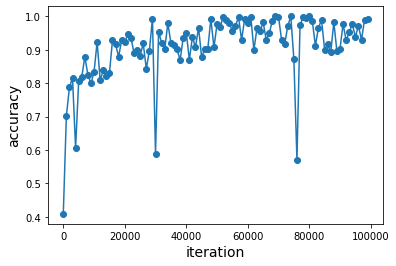

In [18]:
plt.plot(iterations, accuracies, 'o-')
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
# plt.savefig('../fig/dqn.png')
plt.show()